# COM3025 Coursework

## Import Dataset

In [66]:
import numpy as np
from PIL import Image
import h5py
import os
from IPython.display import HTML, display

# This is for displaying the progress bar while importing data
def progress(value, max=100):
    return HTML("""
        Importing Files:
        <progress
            value='{value}'
            max='{max}',
            style='width: 50%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Clone dataset if not already done
![[ -d COM3025 ]] || git clone https://github.com/jw01324/COM3025.git
directory = "./COM3025/Brain Tumor Dataset/Files/"
numberOfFiles = len(os.listdir(directory))

# Create dataset arrays
# Look at README for data structure
labels = np.empty((numberOfFiles,), float) 
images = np.empty((numberOfFiles, 512,512), float) 
tumorBorders = np.empty((numberOfFiles, ), dtype=object)
tumorMask = np.empty((numberOfFiles, 512,512), int) 

# Start showing progress bar
out = display(progress(0, numberOfFiles), display_id=True)

for i,filename in enumerate(os.listdir(directory)):
  # Update progress bar
  out.update(progress(i, numberOfFiles))
  
  with h5py.File(directory + filename, 'r') as file:
    labels[i] = file['cjdata']['label'][()][0][0]
    if len(file['cjdata']['image'][()]) == 512:
      images[i] = np.flipud(np.rot90(file['cjdata']['image'][()]))
      tumorMask[i] = np.flipud(np.rot90(file['cjdata']['tumorMask'][()]))
      tumorBorders[i] = file['cjdata']['tumorBorder'][()][0]
    else: # Some images are 256 so repeat each pixel
      images[i] = np.repeat(np.repeat(np.flipud(np.rot90(file['cjdata']['image'][()])), 2, axis=1), 2, axis=0)
      tumorMask[i] = np.repeat(np.repeat(np.flipud(np.rot90(file['cjdata']['tumorMask'][()])), 2, axis=1), 2, axis=0)
      tumorBorders[i] = [x*2 for x in file['cjdata']['tumorBorder'][()][0]]

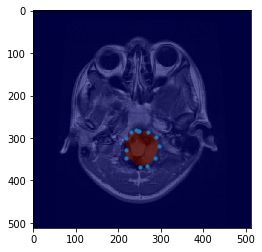

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

i = 82

tumorBordersX = tumorBorders[i][::2]
tumorBordersY = tumorBorders[i][1::2]

plt.imshow(images[i], 'gray', interpolation='none')
plt.imshow(tumorMask[i], 'jet', interpolation='none', alpha=0.5)
plt.scatter(tumorBordersX, tumorBordersY, s=10)
plt.show()